In this notebook we evaluate the explainability of two models : KAN and Random Forest, on the Kin8nm dataset. To do this, we'll be using two popular methods, SHAP and PFI.

In [1]:
!pip install git+https://github.com/KindXiaoming/pykan.git

  Cloning https://github.com/KindXiaoming/pykan.git to /tmp/pip-req-build-ipmwoxlq
  Running command git clone --filter=blob:none --quiet https://github.com/KindXiaoming/pykan.git /tmp/pip-req-build-ipmwoxlq
  Resolved https://github.com/KindXiaoming/pykan.git to commit d51e849bc7e95bc9733d4259e61192ba9bffa697
  Preparing metadata (setup.py) ... done
  Created wheel for pykan: filename=pykan-0.2.8-py3-none-any.whl size=78190 sha256=ca4d65976ec8eb9f57b45c88915c4f03860349ad1d5e1527806857261c76a551
  Stored in directory: /tmp/pip-ephem-wheel-cache-sw23n705/wheels/47/ca/5a/98124e020f3119f51c17f78738c621c140b7aa803b0feda76e
Successfully built pykan


In [2]:
import torch
from kan import KAN

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
import shap

Data Analysis and Cleaning

In [3]:
df = pd.read_csv("/content/dataset_2175_kin8nm.csv")

In [4]:
df

,theta1,theta2,theta3,theta4,theta5,theta6,theta7,theta8,y
0,-0.015119,0.360741,0.469398,1.309675,0.988024,-0.025493,0.664071,0.062763,0.536524
1,0.360478,-0.301395,0.629183,-1.440146,-0.741637,-1.196749,-1.038444,-0.717461,0.308014
2,1.563238,-1.294753,0.078987,1.432937,1.149136,-1.292140,1.562988,-0.937731,0.518900
3,0.199485,0.901157,-1.356304,-0.080525,-0.976628,0.829894,-0.855649,0.930630,0.494151
4,0.659737,0.120552,-0.008756,0.648839,0.626832,-0.646539,1.318074,-0.899172,0.470218
...,...,...,...,...,...,...,...,...,...
8187,1.459523,-0.201551,-0.610721,1.424181,0.269273,1.172781,-0.509818,-0.686006,0.486093
8188,0.654980,-0.823516,-0.809246,0.408441,-1.368838,0.582222,-1.394697,-0.057294,0.696752
8189,0.103862,1.024329,-1.047221,0.280905,-0.181155,-0.651934,-1.241842,1.530220,0.803888
8190,-1.109311,-0.027690,-1.448736,-0.648566,-0.462142,0.814971,1.100615,1.337159,0.887959


In [5]:
df.dropna(inplace=True)
# Prepare input features and labels
X = df.drop('y', axis=1)
y = df['y']

# Ensure X and y do not contain NaNs
X.dropna(inplace=True)
y.dropna(inplace=True)
y = y[X.index]  # Align y with the remaining X

In [6]:
# Splitting the data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=0)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=0)

In [7]:
# Drop NaNs in X_train, X_val, and X_test
X_train.dropna(inplace=True)
X_val.dropna(inplace=True)
X_test.dropna(inplace=True)

y_train.dropna(inplace=True)
y_val.dropna(inplace=True)
y_test.dropna(inplace=True)

In [8]:
# transforming the data
train_input = torch.tensor(X_train.to_numpy(), dtype=torch.float32)
train_label = torch.tensor(y_train.to_numpy(), dtype=torch.float32).view(-1, 1)
val_input = torch.tensor(X_val.to_numpy(), dtype=torch.float32)
val_label = torch.tensor(y_val.to_numpy(), dtype=torch.float32).view(-1, 1)
test_input = torch.tensor(X_test.to_numpy(), dtype=torch.float32)
test_label = torch.tensor(y_test.to_numpy(), dtype=torch.float32).view(-1, 1)

In [9]:
# creating the dataset
dataset = {
    'train_input': train_input,
    'train_label': train_label,
    'val_input': val_input,
    'val_label': val_label,
    'test_input': test_input,
    'test_label': test_label
}

Random forest Model

In [10]:
# Initialize Random Forest Regressor with best parameters
best_rf_model = RandomForestRegressor(
    max_depth=None,
    max_samples=0.5,
    min_samples_leaf=1,
    n_estimators=100,
    random_state=1
)

# Fit the model on the training data
best_rf_model.fit(X_train, y_train)


RandomForestRegressor(max_samples=0.5, random_state=1)

In [11]:

# Make predictions using the best model
train_preds_rf = best_rf_model.predict(X_train)
val_preds_rf = best_rf_model.predict(X_val)
test_preds_rf = best_rf_model.predict(X_test)

# Evaluate metrics

print("Train R2 Score:", r2_score(y_train, train_preds_rf))
print("Train MAE:", mean_absolute_error(y_train, train_preds_rf))

print("Validation R2 Score:", r2_score(y_val, val_preds_rf))
print("Validation MAE:", mean_absolute_error(y_val, val_preds_rf))

print("Test R2 Score:", r2_score(y_test, test_preds_rf))
print("Test MAE:", mean_absolute_error(y_test, test_preds_rf))

Train R2 Score: 0.8817848746288965
Train MAE: 0.07160823445506627
Validation R2 Score: 0.6715250638873926
Validation MAE: 0.11944092167874695
Test R2 Score: 0.6728192114939278
Test MAE: 0.11827388757355575


Ordered Feature Importance (PFI):
  Feature  Importance   Std Dev
2  theta3    0.044631  0.000876
4  theta5    0.019399  0.001317
5  theta6    0.018327  0.000890
6  theta7    0.017818  0.001012
3  theta4    0.010479  0.000527
7  theta8    0.005386  0.000266
0  theta1    0.003015  0.000367
1  theta2    0.002310  0.000148


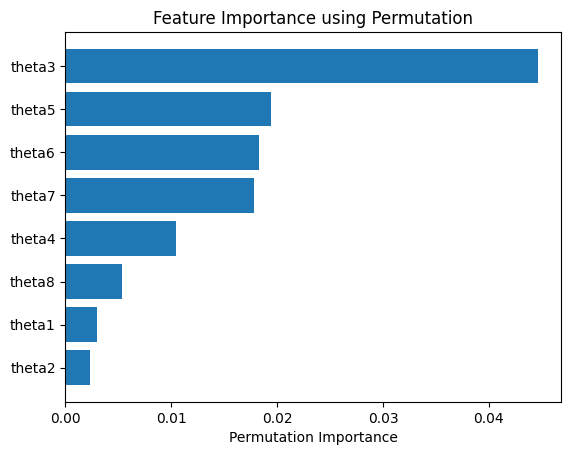

In [12]:
# Calculate PFI using permutation_importance from Scikit-learn
pfi_result = permutation_importance(best_rf_model, X_test, y_test, n_repeats=10, random_state=42, scoring='neg_mean_squared_error')

# Create a DataFrame to store the importance results
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': pfi_result.importances_mean,
    'Std Dev': pfi_result.importances_std
})

# Sort the features by importance
feature_importances_sorted = feature_importances.sort_values(by='Importance', ascending=False)


print("Ordered Feature Importance (PFI):")
print(feature_importances_sorted)

# Plot the feature importance in descending order
plt.barh(feature_importances_sorted['Feature'], feature_importances_sorted['Importance'])
plt.xlabel("Permutation Importance")
plt.title("Feature Importance using Permutation")
plt.gca().invert_yaxis()
plt.show()

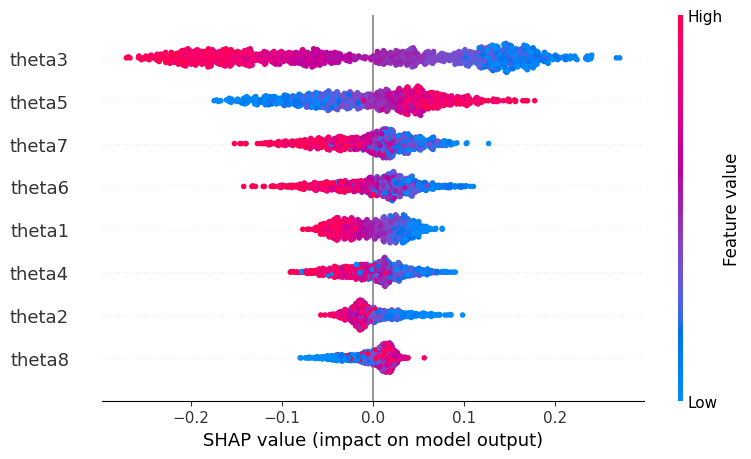

In [14]:
# Initialize SHAP explainer for the Random Forest model
explainer = shap.TreeExplainer(best_rf_model)

# Calculate SHAP values for the test set
shap_values_rf = explainer(X_test)

shap_importances = pd.DataFrame({
    'Feature': X_test.columns,
    'Importance': np.abs(shap_values_rf.values).mean(axis=0)
})
shap_importances_sorted = shap_importances.sort_values(by='Importance', ascending=False)

# Summary plot of SHAP values
shap.summary_plot(shap_values_rf, X_test)



Agreement metric for RF

In [15]:
# Function to measure greement for the top k features using Jaccard Index
def agreement_metric(top_k_shap, top_k_pfi):
    set_shap = set(top_k_shap)
    set_pfi = set(top_k_pfi)

    intersection = len(set_shap.intersection(set_pfi))
    union = len(set_shap.union(set_pfi))

    score = intersection / union if union != 0 else 0
    return score

In [17]:
# Define k the number of top features to compare
k = 4

# Extract top k features
top_k_shap = shap_importances_sorted['Feature'][:k]
top_k_pfi = feature_importances_sorted['Feature'][:k]

score = agreement_metric(top_k_shap, top_k_pfi)
print(f"Agreement metric for the top {k} features using Random Forest: {score:.4f}")

Agreement metric for the top 4 features using Random Forest: 1.0000


KAN Model

In [ ]:
# Create the KAN model
model = KAN(width=[8, 5, 1], grid=5, k=3, seed=0)  # one hidden layer with 5 neurons

checkpoint directory created: ./model
saving model version 0.0


In [ ]:
from sklearn.metrics import mean_squared_error
results = model.fit(
    {'train_input': train_input, 'train_label': train_label, 'test_input': val_input, 'test_label': val_label},
    opt="LBFGS", steps=50, loss_fn=torch.nn.MSELoss() # Use MSELoss for regression
)


| train_loss: 8.45e-02 | test_loss: 9.12e-02 | reg: 1.68e+01 | : 100%|█| 50/50 [01:14<00:00,  1.49s/

saving model version 0.1


In [ ]:
# Predictions of train val and test datasets
test_preds = model.forward(test_input).detach()
test_labels = test_label

train_preds = model.forward(train_input).detach()
train_labels = train_label

val_preds = model.forward(val_input).detach()
val_labels = val_label

# Evaluate metrics
print("Train R2 Score:", r2_score(train_labels.numpy(), train_preds.numpy()))
print("Train MAE:", mean_absolute_error(train_labels.numpy(), train_preds.numpy()))

print("Val R2 Score:", r2_score(val_labels.numpy(), val_preds.numpy()))
print("Val MAE:", mean_absolute_error(val_labels.numpy(), val_preds.numpy()))

print("Test R2 Score:", r2_score(test_labels.numpy(), test_preds.numpy()))
print("Test MAE:", mean_absolute_error(test_labels.numpy(), test_preds.numpy()))

Train R2 Score: 0.8975262641906738
Train MAE: 0.06513231
Val R2 Score: 0.879961371421814
Val MAE: 0.06926097
Test R2 Score: 0.8807703256607056
Test MAE: 0.069563776


PFI KAN

  Feature  Importance
2  theta3    0.052568
5  theta6    0.047739
6  theta7    0.044893
4  theta5    0.038574
3  theta4    0.026439
7  theta8    0.022598
0  theta1    0.005570
1  theta2    0.004764


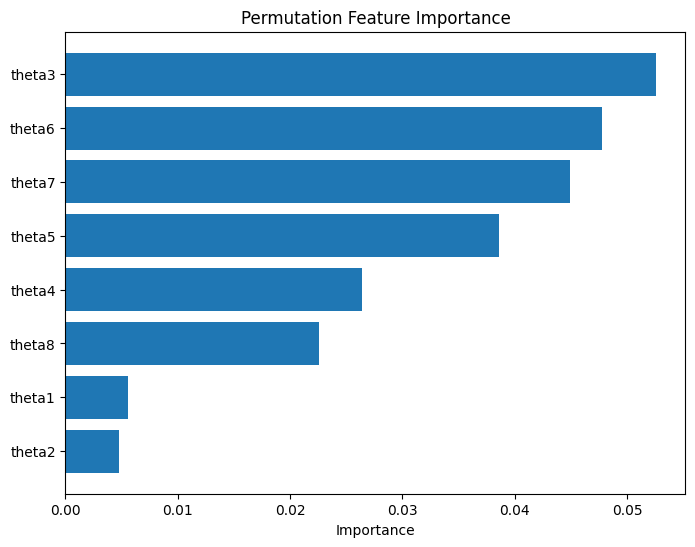

In [ ]:
# Function to evaluate model performance using MSE
def evaluate_model(model, X, y):
    model.eval()
    with torch.no_grad():
        predictions = model(torch.tensor(X, dtype=torch.float32)).numpy()
    return mean_squared_error(y, predictions)

# Calculate permutation feature importance
def permutation_importance(model, X, y, metric=evaluate_model, n_repeats=10):
    baseline_score = metric(model, X, y)
    importances = np.zeros(X.shape[1])

    for i in range(X.shape[1]):
        scores = []
        for _ in range(n_repeats):
            X_permuted = X.copy()
            np.random.shuffle(X_permuted[:, i])
            score = metric(model, X_permuted, y)
            scores.append(score)
        importances[i] = np.mean(scores) - baseline_score

    return importances


# Convert validation data to numpy arrays
X_val_tensor = X_val.to_numpy()
y_val_tensor = y_val.to_numpy()


# Calculate feature importances
importances = permutation_importance(model, X_val_tensor, y_val_tensor)

# Create DataFrame with feature importances
feature_names = X_train.columns
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(importance_df)

# Plot the feature importances
plt.figure(figsize=(8, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Permutation Feature Importance')
plt.gca().invert_yaxis()
plt.show()

SHAP for KAN

  0%|          | 0/1000 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/kan/MultKAN.py:798: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1808.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
/usr/local/lib/python3.10/dist-packages/kan/MultKAN.py:808: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1808.)
  input_range = torch.std(preacts, dim=0) + 0.1
/usr/local/lib/python3.10/dist-packages/kan/MultKAN.py:809: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1808.)
  output_range_spline = torch.std(postacts_numerical, dim

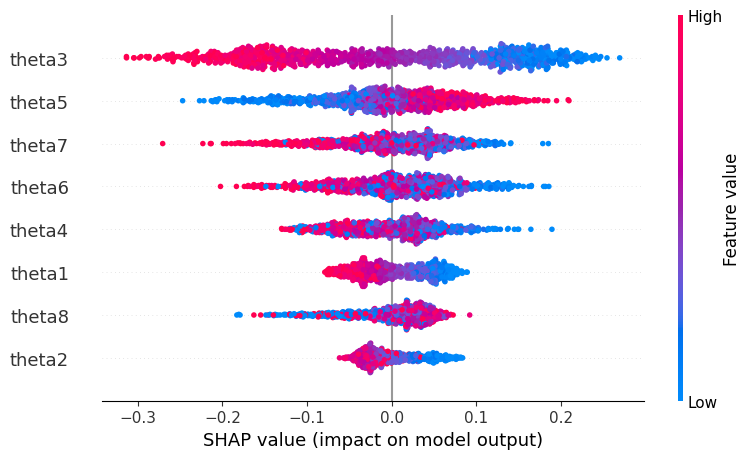

In [ ]:
# Prediction function
def predict_fn(data):
    data_tensor = torch.tensor(data, dtype=torch.float32)
    with torch.no_grad():
        preds = model(data_tensor).numpy()
    return preds

# Sampling
X_train_sample = X_train.sample(1000, random_state=42).to_numpy()
X_test_sample = X_test.sample(1000, random_state=42).to_numpy()

# Initialize the SHAP KernelExplainer
explainer = shap.KernelExplainer(predict_fn, X_train_sample)

# Calculate SHAP values for the sample of the test set
shap_values = explainer.shap_values(X_test_sample)

# If shap_values is a list, select the first output
if isinstance(shap_values, list):
    shap_values = shap_values[0]

# squeeze the SHAP values to remove the singleton dimension
shap_values = np.squeeze(shap_values)

# Create the DataFrame for SHAP values
shap_df = pd.DataFrame(shap_values, columns=X_test.columns)

# Plot SHAP summary plot
shap.summary_plot(shap_values, X_test_sample, feature_names=X_test.columns)


Agreement metric for KAN

In [18]:
#Creating lists of top k features of shap and pfi for KAN
k = 4
top_k_pfi_features_kan = ['theta3', 'theta6', 'theta7', 'theta5']
top_k_shap_features_kan = ['theta3', 'theta5', 'theta7', 'theta6']

# Compute the agreement metric
score_kan = agreement_metric(top_k_shap_features_kan, top_k_pfi_features_kan)
print(f"Agreement metric for the top {k} features using KAN: {score_kan:.4f}")

Agreement metric for the top 4 features using KAN: 1.0000
